In [20]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

# CM-DVR functions
# generate grids - https://github.com/ScottHabershon/PS/blob/main/src/grids.py

def get_exact_grid(x_min: float, x_max: float, exact_grid_size: int) -> npt.NDArray:
    """
    Generates linearly space grid to be used in the exact solver.

    :param x_min: minimum value of the grid
    :type x_min: float
    :param x_max: maximium value of the grid
    :type x_max: float
    :param exact_grid_size: size of the grid used in the exact solver
    :type exact_grid_size: int
    :return: xgrid_exact
    :rtype: npt.NDArray
    """
    xgrid_exact = np.linspace(x_min, x_max, exact_grid_size)
    dx = xgrid_exact[1] - xgrid_exact[0]
    return xgrid_exact, dx

# generate 1D potentials
# 0.5kx^2 - harmonic oscillator

def harmonic_oscillator(k: float, grid: npt.NDArray):
    """
    Sets up a harmonic oscillator potential on a provided grid.

    Args:
        k: force/spring constant

    Returns:
        v[:]: 1-D potential energy, calculated at grid points.
    """
    v = 0.5 * k * (grid ** 2) # 0.5kx^2
    # v = 0.25 * grid**4 # Manolopoulos (2004)
    return v

# solve Schrödinger eqn for potentials - DVR
# CM DVR taken from https://github.com/ScottHabershon/PS/blob/main/src/exact_solver.py

def colbert_miller_DVR(ngrid, x, m, v):
    """
    Performs Colbert-Miller DVR solution of 1-D Schrodinger equation.

    Args:
        ngrid: Number of grid points
        x[:]: Positions of grid points.
        m: mass of particle
        v[:]: 1-D potential energy, calculated at grid points.

    Returns:
        c[:,0]: The ground-state wavefunction.
    """

    #  Atomic units:
    hbar = 1.0

    # Set grid spacing.
    dx = x[1] - x[0]

    #  Set up potential energy matrix.
    V = np.zeros((ngrid, ngrid))
    for i in range(ngrid):
        V[i, i] = v[i]

    #  Set up kinetic energy matrix.
    T = np.zeros((ngrid, ngrid))
    for i in range(ngrid):
        for j in range(ngrid):
            if i == j:
                T[i, j] = ((hbar ** 2) * np.pi ** 2) / (6 * m * dx ** 2)
            else:
                T[i, j] = ((hbar ** 2) * (-1.0) ** (i - j)) / (m * dx ** 2 * (i - j) ** 2)

    # Create the Hamiltonian matrix:
    H = T + V

    #  Solve the eigenvalue problem using the linalg.eigh
    E, c = np.linalg.eigh(H)
    E = E.astype('float128',copy=False)

    #  Normalize each eigenfunction using simple quadrature.
    for i in range(ngrid):
        csum = np.trapz(np.conj(c[:,i]) * c[:,i], x)
        c[:, i] = c[:, i] / np.sqrt(csum)
        E[i] = np.real(E[i])

    return c, E, H

In [21]:
# calculate Kubo TCF from CM-DVR results

def Kubo_TCF(beta, grid, E, c, dx, times):
    Z = 0.0
    for i in range(0, len(E)):
        Z += np.exp(-beta * E[i])

    nt = len(times)
    C = np.zeros(nt, dtype = 'complex')

    for i in range(10):
       for j in range(10):
            t1 = np.exp(-beta*E[i])
            t2 = np.exp(-1j * (E[i]- E[j]) * times) # hbar = 1 - assume atomic units
            Aij = np.trapz(np.conj(c[:,i]) * grid[:] * c[:,j], dx = dx) # integrate over ALL grid points!
            Bji = np.trapz(np.conj(c[:,j]) * grid[:] * c[:,i], dx = dx)
            if i != j: 
                t3 = (1 - np.exp(-beta * (E[j]-E[i]))) / (E[j]-E[i])
            else: # limit of (1 - exp(-beta * x)) / x = beta
                t3 = beta
            C +=  (t1 * t2 * Aij * Bji * t3)
    C /= (beta * Z) 
    return C

In [22]:
# initialise variables
k = 1
m = 1

dt = 0.1
max_time = 20

# run CM DVR
x_min = -10
x_max = 10
grid_size = 101

grid, dx = get_exact_grid(x_min,x_max,grid_size)
v = harmonic_oscillator(k,grid)

# returns c - ground state wavefunction - ith column of c contains wavefunction phi(i), E - eigenvalues, H - hamiltonian, of the system
c, E, H = colbert_miller_DVR(grid_size, grid, m, v)

t = np.arange(0,max_time, dt) # same times used in classical MD
beta = 1

In [23]:
C = Kubo_TCF(beta, grid, E, c, dx, t)

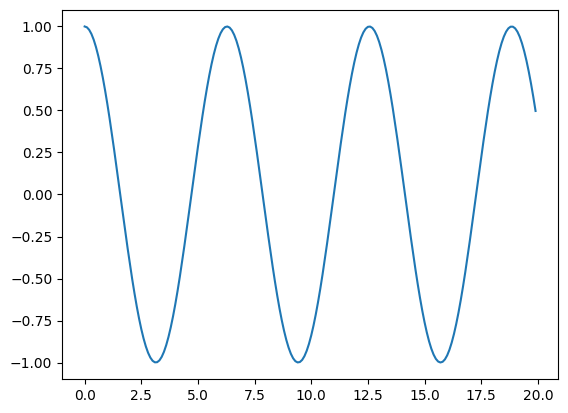

In [24]:
plt.plot(t, C)
plt.show()